In [409]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsvd import NSVD
from norwai_county_test import CNN, ConvModule
import geopandas as gpd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


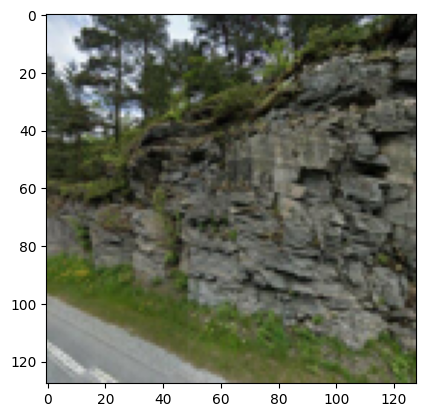

In [410]:
test_images = [{'file':'0013', 'loc':[62.31631851,8.093368]}]
test_im = np.random.choice(test_images, 1)[0]

from PIL import Image

im = Image.open('./data/test_images/{}.png'.format(test_im['file'])).convert('RGB')
w, h = im.size
left = int((w - 512)/2)
top = int((h - 512)/2)
right = int((w + 512)/2)
bottom = int((h + 512)/2)

im = im.crop((left, top, right, bottom)).resize((128, 128))
im_data = torch.tensor(np.asarray(im).transpose(2, 0, 1))

plt.imshow(im_data.int().numpy().transpose(1, 2, 0))
plt.show()

In [411]:
print(im_data)

tensor([[[174, 180, 186,  ...,  36,  21,  35],
         [180, 182, 188,  ...,  17,  43,  40],
         [197, 188, 191,  ...,  38,  48,  19],
         ...,
         [138, 141, 133,  ...,  83,  76,  77],
         [136, 135, 134,  ..., 103,  81,  90],
         [139, 140, 141,  ..., 109,  90,  82]],

        [[198, 200, 200,  ...,  36,  22,  36],
         [200, 200, 201,  ...,  18,  44,  41],
         [212, 202, 204,  ...,  39,  49,  20],
         ...,
         [147, 150, 142,  ...,  93,  84,  95],
         [144, 143, 142,  ..., 115,  87, 103],
         [146, 147, 148,  ..., 123,  96,  90]],

        [[221, 224, 226,  ...,  31,  17,  31],
         [220, 221, 224,  ...,  13,  39,  36],
         [229, 220, 222,  ...,  34,  44,  15],
         ...,
         [147, 150, 142,  ...,  62,  52,  33],
         [147, 147, 145,  ...,  84,  59,  48],
         [152, 153, 153,  ...,  79,  63,  57]]], dtype=torch.uint8)


In [412]:
mean = 135.4867 # fix this
std = 64.0806 # fix this
im_data = im_data.to(device)
im_data = (im_data - mean) / std

model = torch.load('./data/model_classification')
model.to(device)

guessed_county = None
with torch.no_grad():
  y = model(im_data.unsqueeze(0)).flatten()
  print(torch.exp(y))
  guessed_county = torch.argmax(torch.exp(y)).item()


tensor([0.0031, 0.0009, 0.0557, 0.7620, 0.0010, 0.0111, 0.0027, 0.0507, 0.0072,
        0.0031, 0.1024], device='cuda:0')


tensor([-2.7660, -4.7697, -0.9924, -2.6751, -4.7380, -4.6915, -3.9974, -1.0149,
        -3.5734, -3.2383, -3.7712], device='cuda:0')

        tensor([0.0229, 0.0040, 0.1579, 0.0185, 0.0032, 0.0243, 0.0349, 0.4960, 0.0541,
        0.1400, 0.0442], device='cuda:0')

In [413]:
df = pd.read_json("./data/norge.geojson")
fylker = df["administrative_enheter.fylke"]["features"]

In [414]:
import folium

real_loc = test_im['loc']
FYLKESNUMMER_INDEX = [42, 3, 54, 15, 38, 50, 11, 34, 30, 18, 46]

fylke = None

for f in fylker:
    if int(f["properties"]["fylkesnummer"]) == FYLKESNUMMER_INDEX[guessed_county]:
        print("found")
        fylke = f
        break


found


In [415]:
print(fylke["properties"]["fylkesnummer"])

15


In [416]:
gdf = gpd.GeoDataFrame.from_features([fylke])

In [417]:
print(fylke)

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-20575.890000000014, 6963321.31], [-25091.800000000047, 6958283.480000001], [-14031.199999999953, 6948377.43], [-14022.48000000004, 6948369.619999999], [-9874.129999999946, 6944651.2700000005], [-8490.929999999935, 6943412.41], [-6563.399999999965, 6941685.8], [-6270.869999999879, 6941099.22], [-919.7399999999907, 6930368.71], [-1056.0300000000861, 6929164.99], [-1094.469999999972, 6928827.300000001], [-1347.270000000135, 6926604.72], [-1475.2200000001467, 6925479.78], [-1506.1200000000536, 6925209.100000001], [1749.0600000000559, 6921564.140000001], [3018.930000000051, 6920142.18], [4947.540000000037, 6917982.62], [4921.72000000003, 6917246.440000001], [4899.999999999942, 6916627.67], [3178.859999999986, 6912316.97], [3487.530000000028, 6912331.82], [3489.060000000056, 6912331.869999999], [3492.1200000001118, 6912331.0600000005], [3500.75, 6912326.79], [3509.9999999998836, 6912319.7700000005], [3516.1500000000233, 6

In [418]:
#gdf = gpd.GeoDataFrame.from_features(fylker)
#sim_geo = gpd.GeoSeries(fylke['geometry']).simplify(tolerance=0.001)
#geo_j = sim_geo.to_json()
gdf = gdf.set_crs(epsg=25833)
gdf = gdf.to_crs(epsg=4326)
geo_j = folium.GeoJson(data=gdf["geometry"][0],
    style_function=lambda x: {'fillColor': 'orange'})


m = folium.Map((64.9701, 13.509217), zoom_start=4)


geo_j.add_to(m)
folium.CircleMarker(location=(real_loc[0], real_loc[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)
m